In [6]:
%run 'basic_functions.ipynb'


In [7]:
def plot_cv_results_comparison_by_dataset(json_file='cv_results.json'):
    """
    Create comparison charts from CV results JSON file with datasets on x-axis.
    Shows datasets vs methods with mean scores and standard deviations.
    Calculates both MAPE and RMSE from fold results automatically.
    """
    
    # Read the JSON file
    try:
        with open(json_file, 'r') as f:
            cv_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found!")
        return
    
    # Parse data and calculate metrics from fold results
    results_data = []
    
    def calculate_mape(actual, predictions):
        """Calculate MAPE, handling zero values"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        mask = actual != 0
        if mask.any():
            return np.mean(np.abs((actual[mask] - predictions[mask]) / actual[mask])) * 100
        else:
            return np.inf
    
    def calculate_rmse(actual, predictions):
        """Calculate RMSE"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        return np.sqrt(np.mean((actual - predictions) ** 2))
    
    for method_name, datasets_list in cv_data.items():
        for dataset_info in datasets_list:
            fold_results = dataset_info.get('fold_results', [])
            
            # Calculate MAPE and RMSE for each fold
            mape_scores = []
            rmse_scores = []
            
            for fold_data in fold_results:
                actual = fold_data['actual']
                predictions = fold_data['predictions']
                
                # Calculate metrics for this fold
                mape_score = calculate_mape(actual, predictions)
                rmse_score = calculate_rmse(actual, predictions)
                
                if np.isfinite(mape_score):
                    mape_scores.append(mape_score)
                if np.isfinite(rmse_score):
                    rmse_scores.append(rmse_score)
            
            # Add MAPE results
            if mape_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'mape',
                    'mean_score': np.mean(mape_scores),
                    'std_score': np.std(mape_scores),
                    'n_splits': len(mape_scores)
                })
            
            # Add RMSE results
            if rmse_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'rmse',
                    'mean_score': np.mean(rmse_scores),
                    'std_score': np.std(rmse_scores),
                    'n_splits': len(rmse_scores)
                })
    
    df = pd.DataFrame(results_data)
    
    # Separate MAPE and RMSE data
    mape_data = df[df['metric'] == 'mape'].copy()
    rmse_data = df[df['metric'] == 'rmse'].copy()

    
    # Colors for different methods
    methods = df['method'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
    method_colors = dict(zip(methods, colors))
    
    # MAPE Plot
    if len(mape_data) > 0:
        plt.figure(figsize=(16, 8))
        datasets = mape_data['dataset'].unique()
        
        x_pos = np.arange(len(datasets))
        bar_width = 0.8 / len(methods) if len(methods) > 0 else 0.8
        
        for i, method in enumerate(methods):
            method_mape = mape_data[mape_data['method'] == method]
            if len(method_mape) == 0:
                continue
                
            # Get scores for each dataset (fill missing with NaN)
            scores = []
            errors = []
            for dataset in datasets:
                dataset_data = method_mape[method_mape['dataset'] == dataset]
                if len(dataset_data) > 0:
                    scores.append(dataset_data['mean_score'].iloc[0])
                    errors.append(dataset_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=method, color=method_colors[method], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Datasets', fontsize=12, fontweight='bold')
        plt.ylabel('MAPE (%)', fontsize=12, fontweight='bold')
        plt.title('MAPE Comparison: Datasets vs Methods', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(methods) - 1) / 2, datasets, rotation=45, ha='right')
        plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(16, 8))
        plt.text(0.5, 0.5, 'No MAPE data available', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
        plt.title('MAPE Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # RMSE Plot
    if False > 0:
        plt.figure(figsize=(16, 8))
        datasets = rmse_data['dataset'].unique()
        
        x_pos = np.arange(len(datasets))
        bar_width = 0.8 / len(methods) if len(methods) > 0 else 0.8
        
        for i, method in enumerate(methods):
            method_rmse = rmse_data[rmse_data['method'] == method]
            if len(method_rmse) == 0:
                continue
                
            # Get scores for each dataset (fill missing with NaN)
            scores = []
            errors = []
            for dataset in datasets:
                dataset_data = method_rmse[method_rmse['dataset'] == dataset]
                if len(dataset_data) > 0:
                    scores.append(dataset_data['mean_score'].iloc[0])
                    errors.append(dataset_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=method, color=method_colors[method], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Datasets', fontsize=12, fontweight='bold')
        plt.ylabel('RMSE', fontsize=12, fontweight='bold')
        plt.title('RMSE Comparison: Datasets vs Methods', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(methods) - 1) / 2, datasets, rotation=45, ha='right')
        plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
    plt.show()
        
    

    
   
    return df


In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

def plot_cv_results_comparison(json_file='cv_results.json'):
    """
    Create comprehensive comparison charts from CV results JSON file.
    Shows methods vs datasets with mean scores and standard deviations.
    Calculates both MAPE and RMSE from fold results automatically.
    """
    
    # Read the JSON file
    try:
        with open(json_file, 'r') as f:
            cv_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found!")
        return
    
    # Parse data and calculate metrics from fold results
    results_data = []
    
    def calculate_mape(actual, predictions):
        """Calculate MAPE, handling zero values"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        mask = actual != 0
        if mask.any():
            return np.mean(np.abs((actual[mask] - predictions[mask]) / actual[mask])) * 100
        else:
            return np.inf
    
    def calculate_rmse(actual, predictions):
        """Calculate RMSE"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        return np.sqrt(np.mean((actual - predictions) ** 2))
    
    for method_name, datasets_list in cv_data.items():
        for dataset_info in datasets_list:
            fold_results = dataset_info.get('fold_results', [])
            
            # Calculate MAPE and RMSE for each fold
            mape_scores = []
            rmse_scores = []
            
            for fold_data in fold_results:
                actual = fold_data['actual']
                predictions = fold_data['predictions']
                
                # Calculate metrics for this fold
                mape_score = calculate_mape(actual, predictions)
                rmse_score = calculate_rmse(actual, predictions)
                
                if np.isfinite(mape_score):
                    mape_scores.append(mape_score)
                if np.isfinite(rmse_score):
                    rmse_scores.append(rmse_score)
            
            # Add MAPE results
            if mape_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'mape',
                    'mean_score': np.mean(mape_scores),
                    'std_score': np.std(mape_scores),
                    'n_splits': len(mape_scores)
                })
            
            # Add RMSE results
            if rmse_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'rmse',
                    'mean_score': np.mean(rmse_scores),
                    'std_score': np.std(rmse_scores),
                    'n_splits': len(rmse_scores)
                })
    
    df = pd.DataFrame(results_data)
    
    # Separate MAPE and RMSE data
    mape_data = df[df['metric'] == 'mape'].copy()
    rmse_data = df[df['metric'] == 'rmse'].copy()

    
    # Colors for different datasets
    datasets = df['dataset'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(datasets)))
    dataset_colors = dict(zip(datasets, colors))
    
    # MAPE Plot
    if len(mape_data) > 0:
        plt.figure(figsize=(16, 8))
        methods = mape_data['method'].unique()
        
        x_pos = np.arange(len(methods))
        bar_width = 0.8 / len(datasets) if len(datasets) > 0 else 0.8
        
        for i, dataset in enumerate(datasets):
            dataset_mape = mape_data[mape_data['dataset'] == dataset]
            if len(dataset_mape) == 0:
                continue
                
            # Get scores for each method (fill missing with NaN)
            scores = []
            errors = []
            for method in methods:
                method_data = dataset_mape[dataset_mape['method'] == method]
                if len(method_data) > 0:
                    scores.append(method_data['mean_score'].iloc[0])
                    errors.append(method_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=dataset, color=dataset_colors[dataset], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Methods', fontsize=12, fontweight='bold')
        plt.ylabel('MAPE (%)', fontsize=12, fontweight='bold')
        plt.title('MAPE Comparison: Methods vs Datasets', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(datasets) - 1) / 2, methods, rotation=45, ha='right')
        plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
   
    # RMSE Plot
   
    


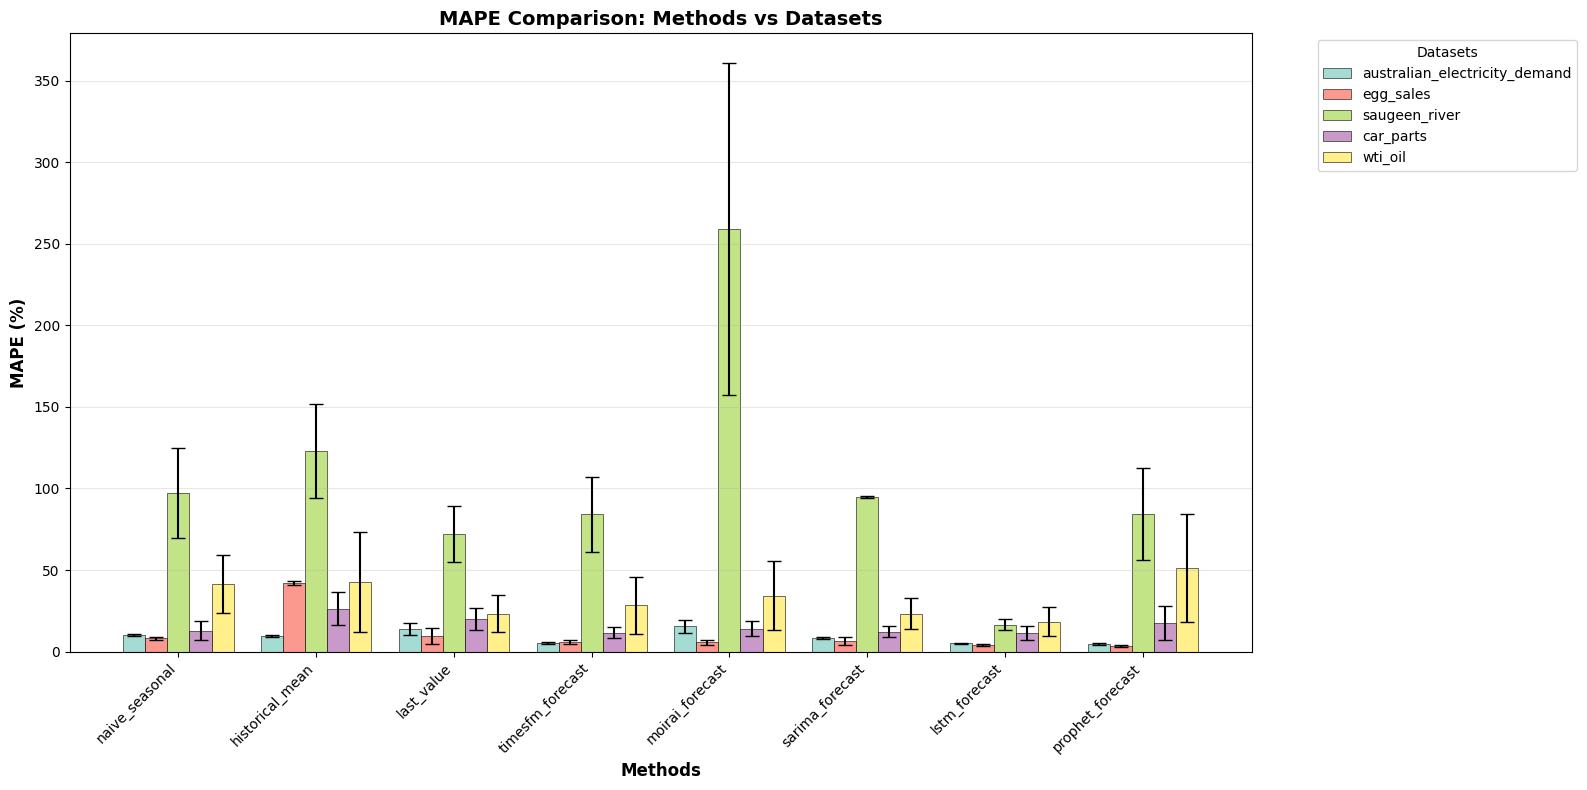

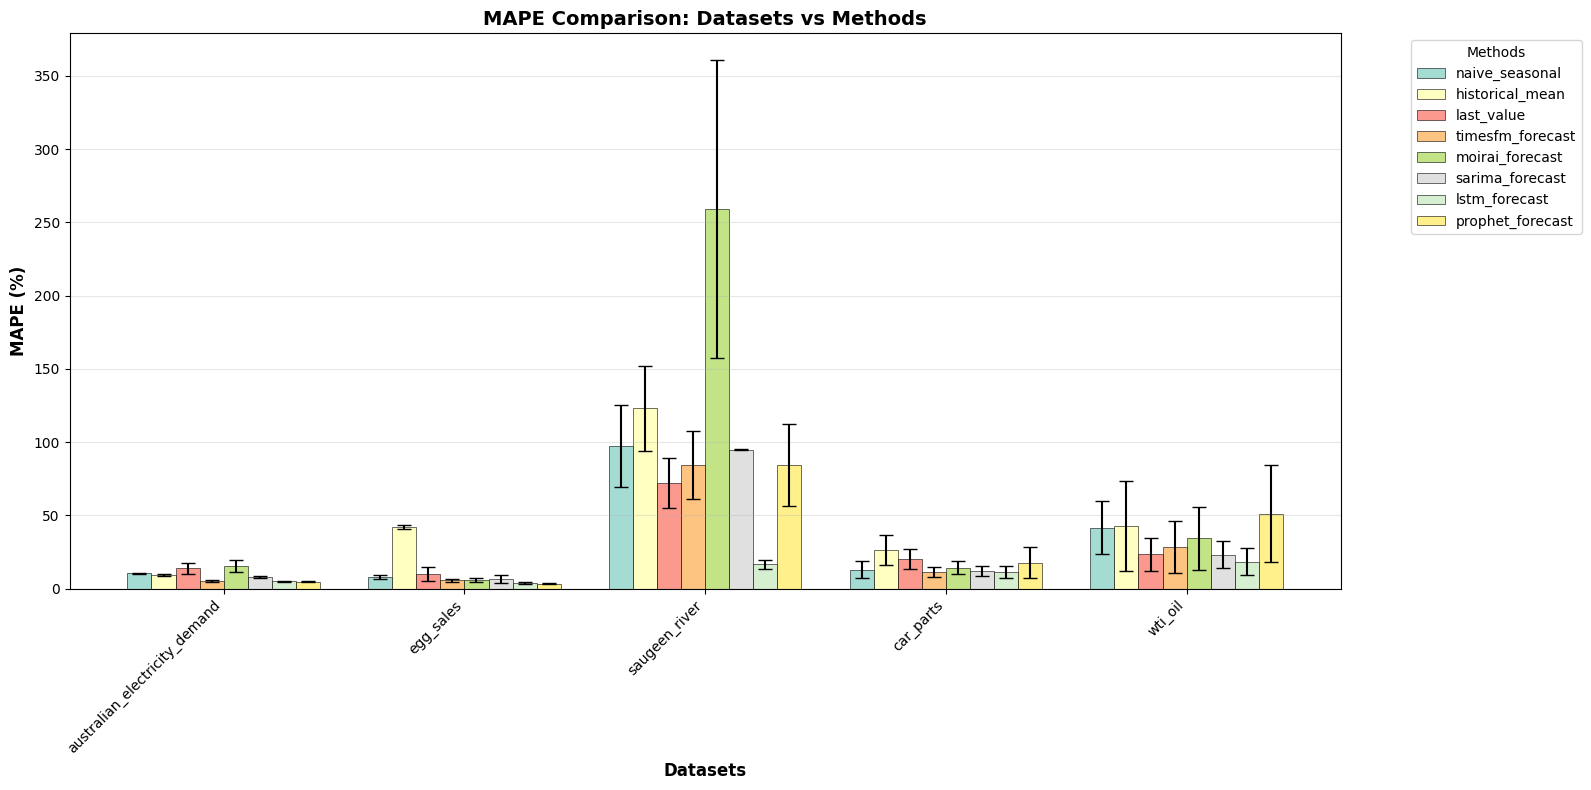

,method,dataset,metric,mean_score,std_score,n_splits
0,naive_seasonal,australian_electricity_demand,mape,10.360578,0.536211,5
1,naive_seasonal,australian_electricity_demand,rmse,30485.581332,1508.573883,5
2,naive_seasonal,egg_sales,mape,8.039919,1.189691,5
3,naive_seasonal,egg_sales,rmse,56.398402,16.889040,5
4,naive_seasonal,saugeen_river,mape,97.264752,27.835620,5
...,...,...,...,...,...,...
75,prophet_forecast,wti_oil,rmse,31.397902,15.655357,5
76,prophet_forecast,egg_sales,mape,3.426709,0.470700,5
77,prophet_forecast,egg_sales,rmse,33.385375,25.193400,5
78,prophet_forecast,car_parts,mape,17.627817,10.604437,5


In [9]:
plot_cv_results_comparison()
plot_cv_results_comparison_by_dataset()


RESIDUAL ANALYSIS: LJUNG-BOX & KOLMOGOROV-SMIRNOV TESTS
Significance level: α = 0.05

Test Interpretations:
• Ljung-Box: Tests for autocorrelation in residuals (p > α = no autocorrelation ✓)
• Kolmogorov-Smirnov: Tests for normality (p > α = normal distribution ✓)

MODELS THAT PASSED BOTH TESTS (6 combinations):
------------------------------------------------------------
✓ naive_seasonal - car_parts (LB p=0.1995, KS p=0.7517)
✓ historical_mean - car_parts (LB p=0.8308, KS p=0.7146)
✓ timesfm_forecast - car_parts (LB p=0.3197, KS p=0.5786)
✓ moirai_forecast - car_parts (LB p=0.8537, KS p=0.8513)
✓ lstm_forecast - car_parts (LB p=0.7580, KS p=0.7980)
✓ prophet_forecast - car_parts (LB p=0.2904, KS p=0.7468)

MODELS THAT FAILED ONE OR BOTH TESTS (34 combinations):
----------------------------------------------------------------------
✗✗ naive_seasonal - australian_electricity_demand (LB p=0.0000, KS p=0.0001)
✗✗ naive_seasonal - egg_sales (LB p=0.0000, KS p=0.0000)
✗✗ naive_seasonal - sa

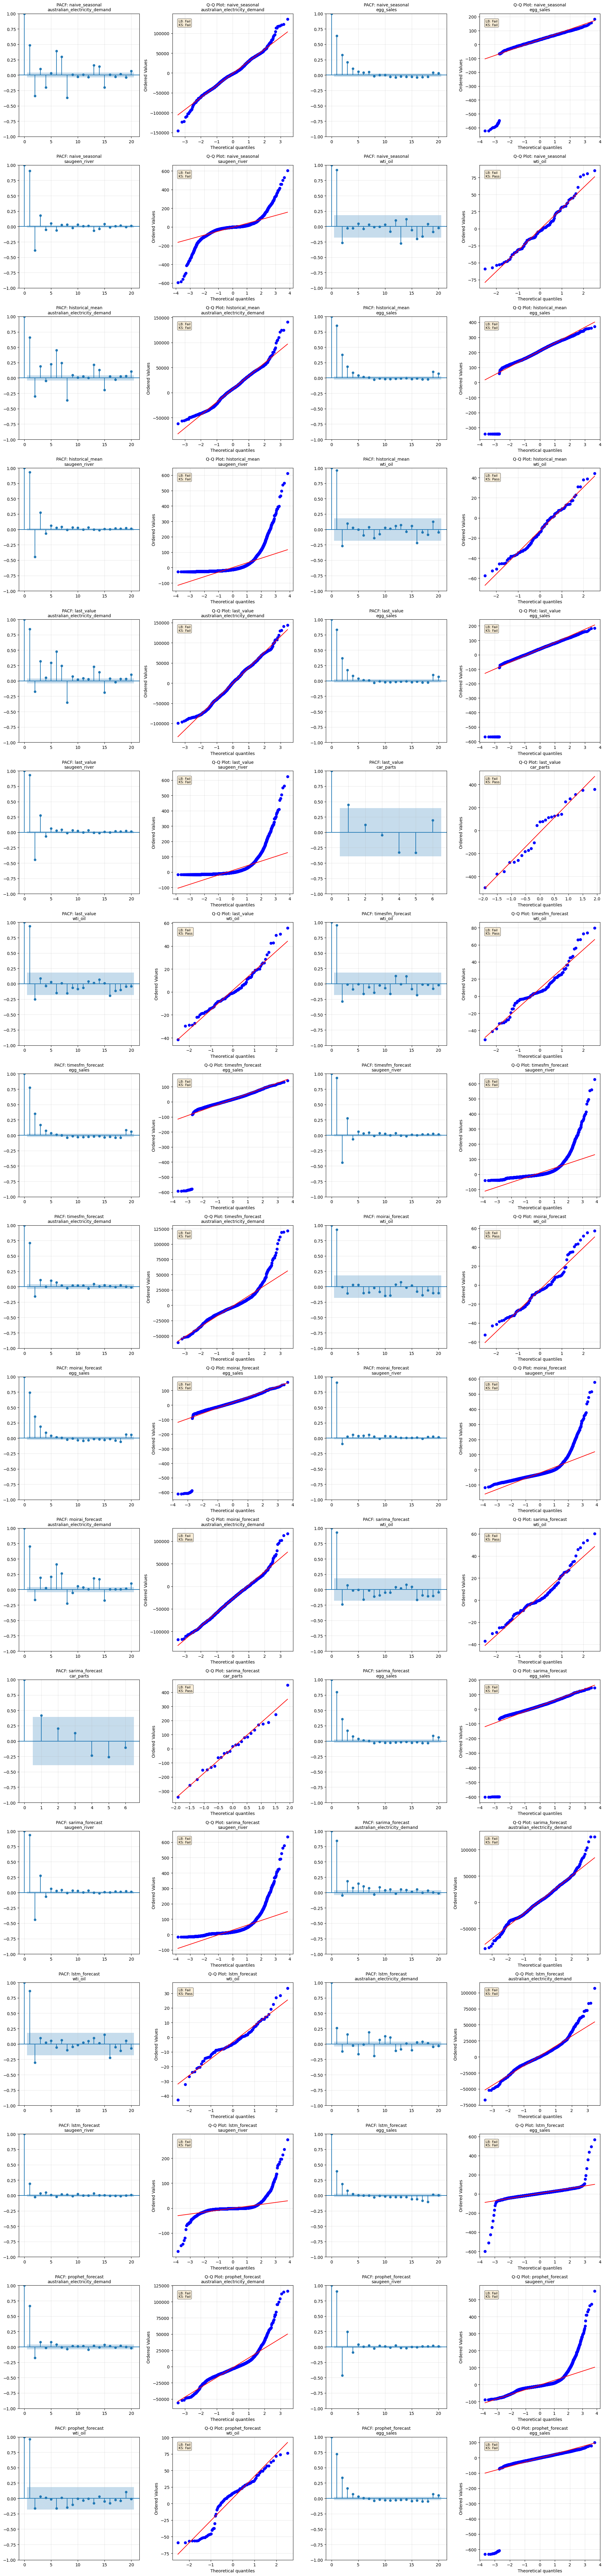


DETAILED TEST RESULTS
          method                       dataset  ljung_box_pvalue  ks_pvalue  ljung_box_pass  ks_pass  both_tests_pass  n_residuals
 historical_mean                     car_parts            0.8308     0.7146            True     True             True           25
   lstm_forecast                     car_parts            0.7580     0.7980            True     True             True           25
 moirai_forecast                     car_parts            0.8537     0.8513            True     True             True           30
  naive_seasonal                     car_parts            0.1995     0.7517            True     True             True           25
prophet_forecast                     car_parts            0.2904     0.7468            True     True             True           25
timesfm_forecast                     car_parts            0.3197     0.5786            True     True             True           25
 historical_mean australian_electricity_demand            0.

In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings('ignore')

def advanced_residual_analysis(json_file='cv_results.json', alpha=0.05):
    """
    Advanced residual analysis with Ljung-Box and Kolmogorov-Smirnov tests.
    Creates PACF and Q-Q plots for models that fail the tests.
    
    Parameters:
    - json_file: Path to CV results JSON file
    - alpha: Significance level for tests (default 0.05)
    """
    
    # Load CV results
    try:
        with open(json_file, 'r') as f:
            cv_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found!")
        return
    
    # Extract residuals for each model-dataset combination
    residual_data = {}
    test_results = []
    
    for method_name, datasets_list in cv_data.items():
        residual_data[method_name] = {}
        for dataset_info in datasets_list:
            dataset_name = dataset_info['dataset_name']
            fold_results = dataset_info.get('fold_results', [])
            
            # Combine residuals from all folds
            combined_residuals = []
            for fold_data in fold_results:
                actual = np.array(fold_data['actual'])
                predictions = np.array(fold_data['predictions'])
                residuals = actual - predictions
                combined_residuals.extend(residuals)
            
            if combined_residuals:
                residuals = np.array(combined_residuals)
                residual_data[method_name][dataset_name] = residuals
                
                # Ljung-Box test for autocorrelation
                max_lags = min(10, len(residuals) // 4)
                if max_lags > 0:
                    try:
                        # Use return_df=True for consistent format
                        lb_result = acorr_ljungbox(residuals, lags=max_lags, return_df=True)
                        lb_pvalue = lb_result['lb_pvalue'].iloc[-1]
                    except Exception as e:
                        print(f"Warning: Ljung-Box test failed for {method_name}-{dataset_name}: {e}")
                        lb_pvalue = np.nan
                else:
                    lb_pvalue = np.nan
                
                # Kolmogorov-Smirnov test for normality (against standard normal)
                # First standardize residuals
                if np.std(residuals) > 0:
                    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
                    ks_stat, ks_pvalue = stats.kstest(standardized_residuals, 'norm')
                else:
                    ks_pvalue = np.nan
                
                # Determine test results
                lb_pass = lb_pvalue > alpha if not np.isnan(lb_pvalue) else False
                ks_pass = ks_pvalue > alpha if not np.isnan(ks_pvalue) else False
                both_pass = lb_pass and ks_pass
                
                test_results.append({
                    'method': method_name,
                    'dataset': dataset_name,
                    'ljung_box_pvalue': lb_pvalue,
                    'ks_pvalue': ks_pvalue,
                    'ljung_box_pass': lb_pass,
                    'ks_pass': ks_pass,
                    'both_tests_pass': both_pass,
                    'n_residuals': len(residuals),
                    'mean_residual': np.mean(residuals),
                    'std_residual': np.std(residuals)
                })
    
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(test_results)
    
    # Print summary
    print("="*80)
    print("RESIDUAL ANALYSIS: LJUNG-BOX & KOLMOGOROV-SMIRNOV TESTS")
    print("="*80)
    print(f"Significance level: α = {alpha}")
    print()
    print("Test Interpretations:")
    print("• Ljung-Box: Tests for autocorrelation in residuals (p > α = no autocorrelation ✓)")
    print("• Kolmogorov-Smirnov: Tests for normality (p > α = normal distribution ✓)")
    print()
    
    # Models that passed both tests
    passed_both = results_df[results_df['both_tests_pass'] == True]
    
    print(f"MODELS THAT PASSED BOTH TESTS ({len(passed_both)} combinations):")
    print("-" * 60)
    if len(passed_both) > 0:
        for _, row in passed_both.iterrows():
            print(f"✓ {row['method']} - {row['dataset']} (LB p={row['ljung_box_pvalue']:.4f}, KS p={row['ks_pvalue']:.4f})")
    else:
        print("❌ No model-dataset combinations passed both tests!")
    print()
    
    # Models that failed tests
    failed_models = results_df[results_df['both_tests_pass'] == False]
    
    print(f"MODELS THAT FAILED ONE OR BOTH TESTS ({len(failed_models)} combinations):")
    print("-" * 70)
    for _, row in failed_models.iterrows():
        lb_status = "✓" if row['ljung_box_pass'] else "✗"
        ks_status = "✓" if row['ks_pass'] else "✗"
        print(f"{lb_status}{ks_status} {row['method']} - {row['dataset']} (LB p={row['ljung_box_pvalue']:.4f}, KS p={row['ks_pvalue']:.4f})")
    
    # Create plots for failed models
    failed_count = len(failed_models)
    if failed_count > 0:
        print(f"\nCreating PACF and Q-Q plots for {failed_count} failed model(s)...")
        
        # Calculate subplot layout
        n_cols = 4  # 2 plots per model (PACF + QQ)
        n_rows = max(1, (failed_count * 2 + n_cols - 1) // n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        plot_idx = 0
        
        for _, row in failed_models.iterrows():
            method = row['method']
            dataset = row['dataset']
            residuals = residual_data[method][dataset]
            
            # PACF Plot
            if plot_idx < n_rows * n_cols:
                ax_pacf = axes[plot_idx // n_cols, plot_idx % n_cols]
                try:
                    max_lags = min(20, len(residuals) // 4)
                    if max_lags > 1:
                        plot_pacf(residuals, lags=max_lags, ax=ax_pacf, alpha=0.05)
                        ax_pacf.set_title(f'PACF: {method}\n{dataset}', fontsize=10)
                        ax_pacf.grid(True, alpha=0.3)
                    else:
                        ax_pacf.text(0.5, 0.5, 'Insufficient data\nfor PACF', 
                                    ha='center', va='center', transform=ax_pacf.transAxes)
                        ax_pacf.set_title(f'PACF: {method}\n{dataset}', fontsize=10)
                except Exception as e:
                    ax_pacf.text(0.5, 0.5, f'PACF Error:\n{str(e)[:30]}...', 
                                ha='center', va='center', transform=ax_pacf.transAxes)
                    ax_pacf.set_title(f'PACF: {method}\n{dataset}', fontsize=10)
                
                plot_idx += 1
            
            # Q-Q Plot
            if plot_idx < n_rows * n_cols:
                ax_qq = axes[plot_idx // n_cols, plot_idx % n_cols]
                try:
                    stats.probplot(residuals, dist="norm", plot=ax_qq)
                    ax_qq.set_title(f'Q-Q Plot: {method}\n{dataset}', fontsize=10)
                    ax_qq.grid(True, alpha=0.3)
                    # Add test results to plot
                    textstr = f'LB: {"Pass" if row["ljung_box_pass"] else "Fail"}\nKS: {"Pass" if row["ks_pass"] else "Fail"}'
                    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                    ax_qq.text(0.05, 0.95, textstr, transform=ax_qq.transAxes, fontsize=8,
                              verticalalignment='top', bbox=props)
                except Exception as e:
                    ax_qq.text(0.5, 0.5, f'Q-Q Error:\n{str(e)[:30]}...', 
                              ha='center', va='center', transform=ax_qq.transAxes)
                    ax_qq.set_title(f'Q-Q Plot: {method}\n{dataset}', fontsize=10)
                
                plot_idx += 1
        
        # Hide empty subplots
        while plot_idx < n_rows * n_cols:
            axes[plot_idx // n_cols, plot_idx % n_cols].set_visible(False)
            plot_idx += 1
        
        plt.tight_layout()
        plt.show()
    
    # Detailed results table
    print("\n" + "="*120)
    print("DETAILED TEST RESULTS")
    print("="*120)
    
    display_df = results_df[['method', 'dataset', 'ljung_box_pvalue', 'ks_pvalue', 
                            'ljung_box_pass', 'ks_pass', 'both_tests_pass', 'n_residuals']].copy()
    display_df = display_df.round({'ljung_box_pvalue': 4, 'ks_pvalue': 4})
    display_df = display_df.sort_values(['both_tests_pass', 'method', 'dataset'], ascending=[False, True, True])
    
    print(display_df.to_string(index=False))
    
    # Summary statistics
    print(f"\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    total_combinations = len(results_df)
    passed_both_count = len(passed_both)
    passed_lb_only = len(results_df[results_df['ljung_box_pass'] == True])
    passed_ks_only = len(results_df[results_df['ks_pass'] == True])
    
    print(f"Total model-dataset combinations: {total_combinations}")
    print(f"Passed both tests: {passed_both_count} ({passed_both_count/total_combinations*100:.1f}%)")
    print(f"Passed Ljung-Box test: {passed_lb_only} ({passed_lb_only/total_combinations*100:.1f}%)")
    print(f"Passed Kolmogorov-Smirnov test: {passed_ks_only} ({passed_ks_only/total_combinations*100:.1f}%)")
    
    return results_df

# Run the advanced residual analysis
residual_test_results = advanced_residual_analysis()
